In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
import lime
import lime.lime_tabular


In [2]:
df = pd.read_csv('/kaggle/input/vehicle-sales-data/car_prices.csv')
df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558837 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558837 non-null  int64  
 1   make          548536 non-null  object 
 2   model         548438 non-null  object 
 3   trim          548186 non-null  object 
 4   body          545642 non-null  object 
 5   transmission  493485 non-null  object 
 6   vin           558833 non-null  object 
 7   state         558837 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558743 non-null  float64
 10  color         558088 non-null  object 
 11  interior      558088 non-null  object 
 12  seller        558837 non-null  object 
 13  mmr           558799 non-null  float64
 14  sellingprice  558825 non-null  float64
 15  saledate      558825 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 68.2+ MB


In [4]:
for feature in df.columns:
    print(f"Столбец {feature}: {df[feature].isnull().sum()} пропусков")

Столбец year: 0 пропусков
Столбец make: 10301 пропусков
Столбец model: 10399 пропусков
Столбец trim: 10651 пропусков
Столбец body: 13195 пропусков
Столбец transmission: 65352 пропусков
Столбец vin: 4 пропусков
Столбец state: 0 пропусков
Столбец condition: 11820 пропусков
Столбец odometer: 94 пропусков
Столбец color: 749 пропусков
Столбец interior: 749 пропусков
Столбец seller: 0 пропусков
Столбец mmr: 38 пропусков
Столбец sellingprice: 12 пропусков
Столбец saledate: 12 пропусков


In [5]:
df = df.dropna(subset=['sellingprice', 'saledate','mmr','vin'])
df['model'] = df['model'].fillna('unknown')
df['trim'] = df['trim'].fillna('unknown')
df['interior'] = df['interior'].fillna('unknown')
df['color'] = df['color'].fillna('unknown')

In [6]:
df['body'].unique()

array(['SUV', 'Sedan', 'Convertible', 'Coupe', 'Wagon', 'Hatchback',
       'Crew Cab', 'G Coupe', 'G Sedan', 'Elantra Coupe', 'Genesis Coupe',
       'Minivan', nan, 'Van', 'Double Cab', 'CrewMax Cab', 'Access Cab',
       'King Cab', 'SuperCrew', 'CTS Coupe', 'Extended Cab',
       'E-Series Van', 'SuperCab', 'Regular Cab', 'G Convertible', 'Koup',
       'Quad Cab', 'CTS-V Coupe', 'sedan', 'G37 Convertible', 'Club Cab',
       'Xtracab', 'Q60 Convertible', 'CTS Wagon', 'convertible',
       'G37 Coupe', 'Mega Cab', 'Cab Plus 4', 'Q60 Coupe', 'Cab Plus',
       'Beetle Convertible', 'TSX Sport Wagon', 'Promaster Cargo Van',
       'GranTurismo Convertible', 'CTS-V Wagon', 'Ram Van', 'minivan',
       'suv', 'Transit Van', 'van', 'regular-cab', 'g sedan', 'g coupe',
       'hatchback', 'king cab', 'supercrew', 'g convertible', 'coupe',
       'crew cab', 'wagon', 'double cab', 'e-series van', 'regular cab',
       'quad cab', 'g37 convertible', 'supercab', 'extended cab',
       'crew

In [7]:
def extract_7th_char(vin):
    return vin[6]

df['VIN_7th'] = df['vin'].apply(extract_7th_char)
df['VIN_7th'].unique()

array(['a', 'c', 't', 's', 'f', 'd', 'h', 'e', 'n', 'k', 'b', 'm', 'j',
       'l', 'g', 'v', 'u', 'z', '8', '6', '1', '3', '2', '0', '7', '4',
       '5', '9', 'w', 'p', 'r', 'x', 'y'], dtype=object)

In [8]:
vin_7th_char_decode = {
    'a': 'Coupe',
    'c': 'Convertible',
    't': 'Hatchback',
    's': 'Sedan',
    'f': 'SUV',
    'd': 'Truck',
    'h': 'High Roof',
    'e': 'Wagon',
    'n': 'Van',
    'k': 'Crossover',
    'b': 'Bus',
    'm': 'Minivan',
    'j': 'Motorcycle',
    'l': 'Limo',
    'g': 'Roadster',
    'v': 'Van with windows',
    'u': 'Utility',
    'z': 'Special vehicle',
    '8': 'Eight-wheel vehicle',
    '6': 'Six-wheel vehicle',
    '1': 'One-wheel vehicle',
    '3': 'Three-wheel vehicle',
    '2': 'Two-wheel vehicle',
    '0': 'Zero-emission vehicle',
    '7': 'Seven-wheel vehicle',
    '4': 'Four-wheel vehicle',
    '5': 'Five-wheel vehicle',
    '9': 'Nine-wheel vehicle',
    'w': 'Wagon',
    'p': 'Pickup truck',
    'r': 'Roadster',
    'x': 'Van with windows',
}    
def decode_vin_body(vin):
    return vin_7th_char_decode.get(vin[7], 'Unknown')
df['VIN_7th'] = df['vin'].apply(decode_vin_body)
df['body'].fillna(df['VIN_7th'], inplace=True)
df=df.drop('VIN_7th', axis=1)

<ipython-input-8-2a0596a0b997>:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['body'].fillna(df['VIN_7th'], inplace=True)


In [9]:
def fill_missing_odometer(row):
    if pd.isna(row['odometer']):
        year = row['year']
        make = row['make']
        
        similar_rows = df[(df['year'] == year) & (df['make'] == make)]
        
        average_odometer = similar_rows['odometer'].median()
        return average_odometer
    return row['odometer']

df['odometer'] = df.apply(fill_missing_odometer, axis=1)

In [10]:
df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce', utc=True)
df['saleyear'] = df['saledate'].dt.year
df = df[(df['saleyear'] >= df['year'])]
df['age'] = df['saleyear']-df['year']
df['saledate'] = df['saledate'].dt.strftime('%Y-%m-%d %H:%M:%S')

<ipython-input-10-03f1effc18f7>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce', utc=True)


In [11]:
df['transmission'].unique()

array(['automatic', nan, 'manual'], dtype=object)

In [12]:
df['transmission_aut'] = df['transmission'] == 'automatic'
df['transmission_man'] = df['transmission'] == 'manual'
df['transmission_sed'] = df['transmission'].isin(['sedan', 'Sedan'])
df=df.drop('transmission', axis=1)

In [13]:
df['type'] = df['vin'].str[3:5]

In [14]:
df['make'].unique()

array(['BMW', 'Volvo', 'Chevrolet', 'Audi', 'Ford', 'Buick', 'Cadillac',
       'Acura', 'Kia', 'Nissan', 'Hyundai', 'Infiniti', 'Jeep',
       'Mercedes-Benz', 'Lexus', 'Mitsubishi', 'Mazda', 'MINI',
       'Land Rover', 'Lincoln', 'lincoln', 'Jaguar', 'Volkswagen',
       'Toyota', 'Subaru', 'Scion', 'Porsche', nan, 'bmw', 'Dodge',
       'FIAT', 'Chrysler', 'ford', 'Ferrari', 'Honda', 'GMC',
       'mitsubishi', 'Ram', 'smart', 'chevrolet', 'Bentley', 'chrysler',
       'pontiac', 'Pontiac', 'Saturn', 'Maserati', 'Mercury', 'HUMMER',
       'landrover', 'cadillac', 'land rover', 'mercedes', 'mazda',
       'toyota', 'lexus', 'gmc truck', 'honda', 'nissan', 'porsche',
       'Saab', 'Suzuki', 'dodge', 'subaru', 'Oldsmobile', 'oldsmobile',
       'hyundai', 'jeep', 'Isuzu', 'dodge tk', 'Geo', 'acura',
       'volkswagen', 'suzuki', 'kia', 'audi', 'Rolls-Royce', 'gmc',
       'maserati', 'mazda tk', 'mercury', 'buick', 'hyundai tk',
       'mercedes-b', 'vw', 'Daewoo', 'chev truck', 'f

In [15]:
def get_maker_info(row):
    if pd.isna(row['make']):
        return row['vin'][1:3]
    return 'No missing make'
df['Maker_Info'] = df.apply(get_maker_info, axis=1)
df['Maker_Info'].unique()

array(['No missing make', 'ba', 'al', 'ft', 'fa', 'p0', 'g1', 'gn', 'hj',
       'm1', 'g2', 'gc', 'c4', 'a3', 'gb', 'y2', 'cn', 'd8', 'fm', 'tj',
       'm3', 'am', 'db', 'dd', 'f1', 'a4', 'fd', 'gd', 'hk', 'j4', 'f2',
       'n1', 'me', 'vw', 'gy', 'mh', 'c8', 'd4', 'b3', 'hg', 'm2', 'yv',
       's3', 'gk', 'na', 'b4', 'b7', 'gt', 'n2', 't3', 'p4', 'fb', 'bx',
       'l2', 'hm', 'g6', 'tb', 'm8', 'c3', 'td', 'au', 't1', 'tf', 'fn',
       'ln', 'a8', 'gm', 'g3', 'd6', 'vg', 'h4', 'dc', 'th', 'yf', 's2',
       'te', 'l5', 'nd', 'gh', 'lm', 'hl', 'd3', 'nm', 'ga', 'n8', 'l1',
       'd2', 'g4', 'hh', 'b6', 'v2', 'dy', 'y1', 'ta', 'tm', 'n6', 'p1',
       '37', 'gs', 'g8', 'gl', 'jc', 'f4', 't4', 't2', 'da', 'ru', 'ge',
       'gr', 'd7', 'ff', 'aj', 'gz', 'bw', 'a1', 'dz', 'hs', 'bs', 'p3'],
      dtype=object)

In [16]:
vin_manufacturer = {
    'ba': 'Bayerische Motoren Werke AG (BMW)',
    'al': 'Autonomous vehicle maker (Hypothetical)',
    'ft': 'Fiat',
    'fa': 'Faw Jilin',
    'p0': 'Polestar',
    'g1': 'General Motors',
    'gn': 'Genesis',
    'hj': 'Honda',
    'm1': 'Mazda',
    'g2': 'Geely',
    'gc': 'GM China',
    'c4': 'Chery',
    'a3': 'Aston Martin',
    'gb': 'Great Wall',
    'y2': 'BYD',
    'cn': 'Changan',
    'd8': 'Daihatsu',
    'fm': 'Fiat Manufacturing',
    'tj': 'Tata',
    'm3': 'Mitsubishi',
    'am': 'Alfa Romeo',
    'db': 'Daimler AG',
    'dd': 'Dodge',
    'f1': 'Ford',
    'a4': 'Audi',
    'fd': 'Fiat',
    'gd': 'General Motors Daewoo',
    'hk': 'Hyundai',
    'j4': 'Jaguar',
    'f2': 'Fiat',
    'n1': 'Nissan',
    'me': 'Mercedes-Benz',
    'vw': 'Volkswagen',
    'gy': 'GAC (Guangzhou Automobile Group)',
    'mh': 'Mahindra',
    'c8': 'Changan',
    'd4': 'Dongfeng',
    'b3': 'BAIC Group',
    'hg': 'Hyundai',
    'm2': 'Mazda',
    'yv': 'Volvo',
    's3': 'Saab',
    'gk': 'Kia',
    'na': 'Nissan',
    'b4': 'Brilliance',
    'b7': 'BMW Brilliance',
    'gt': 'General Motors (Thailand)',
    'n2': 'Nissan',
    't3': 'Tesla',
    'p4': 'Peugeot',
    'fb': 'Fiat',
    'bx': 'BYD',
    'l2': 'Lotus',
    'hm': 'Honda Manufacturing',
    'g6': 'General Motors (Korea)',
    'tb': 'Tata',
    'm8': 'Mitsubishi',
    'c3': 'Chevrolet',
    'td': 'Tesla',
    'au': 'Audi',
    't1': 'Toyota',
    'tf': 'Toyota',
    'fn': 'Fiat',
    'ln': 'Lincoln',
    'a8': 'Aston Martin',
    'gm': 'General Motors',
    'g3': 'GM Korea',
    'd6': 'Dacia',
    'vg': 'Volkswagen',
    'h4': 'Honda',
    'dc': 'Daimler Chrysler',
    'th': 'Toyota',
    'yf': 'Yamaha',
    's2': 'Suzuki',
    'te': 'Tesla',
    'l5': 'Lada',
    'nd': 'Nissan Diesel',
    'gh': 'General Motors',
    'lm': 'Lamborghini',
    'hl': 'Hino',
    'd3': 'Daihatsu',
    'nm': 'Nissan',
    'ga': 'Geely',
    'n8': 'Nissan',
    'l1': 'Lexus',
    'd2': 'Daihatsu',
    'g4': 'GM Daewoo',
    'hh': 'Honda',
    'b6': 'Brilliance',
    'v2': 'Volvo',
    'dy': 'Dyna',
    'y1': 'Yamaha',
    'ta': 'Tata',
    'tm': 'Toyota',
    'n6': 'Nissan',
    'p1': 'Peugeot',
    '37': 'Peugeot',
    'gs': 'General Motors (China)',
    'g8': 'GM Korea',
    'gl': 'GMC',
    'jc': 'Jeep',
    'f4': 'Fiat',
    't4': 'Tesla',
    't2': 'Tesla',
    'da': 'Daihatsu',
    'ru': 'Renault',
    'ge': 'Geely',
    'gr': 'General Motors',
    'd7': 'Daihatsu',
    'ff': 'Ford',
    'aj': 'Aston Martin',
    'gz': 'General Motors',
    'bw': 'Brilliance',
    'a1': 'Aston Martin',
    'dz': 'Daimler AG',
    'hs': 'Hummer',
    'bs': 'BYD',
    'p3': 'Peugeot'
}
def decode_vin_maker(vin):
    return vin_manufacturer.get(vin[1:3], 'Unknown')
df['Maker_Info'] = df['vin'].apply(decode_vin_maker)
df['make'].fillna(df['Maker_Info'], inplace=True)
df['Maker_Info'].value_counts()

<ipython-input-16-3cbdeaa1ac05>:124: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['make'].fillna(df['Maker_Info'], inplace=True)


Maker_Info
Unknown                  88430
Nissan                   47332
Faw Jilin                33387
General Motors           32350
Fiat                     32204
                         ...  
General Motors Daewoo       19
Dacia                        6
Dyna                         4
GMC                          2
Jeep                         1
Name: count, Length: 67, dtype: int64

In [17]:
df=df.drop('Maker_Info', axis=1)

In [18]:
def get_first_character(vin):
    return vin[0]

df['first_character'] = df['vin'].apply(get_first_character)
df['first_character'].unique()

array(['w', 'y', '1', '2', '3', '5', 'k', 't', 'j', '4', 's', 'z', 'n',
       '6', '9', 'v', 'm'], dtype=object)

In [19]:
vin_country = {
    'w': 'Germany',
    'y': 'Sweden',
    '1': 'USA',
    '2': 'Canada',
    '3': 'Mexico',
    '5': 'USA',
    'k': 'Korea',
    't': 'Czech Republic',
    'j': 'Japan',
    '4': 'USA',
    's': 'United Kingdom',
    'z': 'Italy',
    'n': 'Norway',
    '6': 'Australia',
    '9': 'Brazil',
    'v': 'France/Spain',
    'm': 'India'
}
def decode_vin_country(vin):
    return vin_country.get(vin[0], 'unknown')
df['country'] = df['vin'].apply(decode_vin_country)
df=df.drop('first_character', axis=1)
df['country'].value_counts()

country
USA               288769
Canada             73094
Japan              64091
Mexico             51711
Germany            46844
Korea              23750
United Kingdom      4264
Sweden              4215
Norway               700
Italy                474
Australia            209
India                189
Czech Republic       143
Brazil               106
France/Spain          39
Name: count, dtype: int64

In [20]:
for feature in df.columns:
    print(f"Столбец {feature}: {df[feature].isnull().sum()} пропусков")

Столбец year: 0 пропусков
Столбец make: 0 пропусков
Столбец model: 0 пропусков
Столбец trim: 0 пропусков
Столбец body: 0 пропусков
Столбец vin: 0 пропусков
Столбец state: 0 пропусков
Столбец condition: 11767 пропусков
Столбец odometer: 4 пропусков
Столбец color: 0 пропусков
Столбец interior: 0 пропусков
Столбец seller: 0 пропусков
Столбец mmr: 0 пропусков
Столбец sellingprice: 0 пропусков
Столбец saledate: 0 пропусков
Столбец saleyear: 0 пропусков
Столбец age: 0 пропусков
Столбец transmission_aut: 0 пропусков
Столбец transmission_man: 0 пропусков
Столбец transmission_sed: 0 пропусков
Столбец type: 0 пропусков
Столбец country: 0 пропусков


In [21]:
df.head()

,year,make,model,trim,body,vin,state,condition,odometer,color,...,mmr,sellingprice,saledate,saleyear,age,transmission_aut,transmission_man,transmission_sed,type,country
2,2014,BMW,3 Series,328i SULEV,Sedan,wba3c1c51ek116351,ca,45.0,1331.0,gray,...,31900.0,30000.0,2015-01-14 20:30:00,2015,1,True,False,False,3c,Germany
3,2015,Volvo,S60,T5,Sedan,yv1612tb4f1310987,ca,41.0,14282.0,white,...,27500.0,27750.0,2015-01-28 20:30:00,2015,0,True,False,False,61,Sweden
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,wba6b2c57ed129731,ca,43.0,2641.0,gray,...,66000.0,67000.0,2014-12-18 04:30:00,2014,0,True,False,False,6b,Germany
6,2014,BMW,M5,Base,Sedan,wbsfv9c51ed593089,ca,34.0,14943.0,black,...,69000.0,65000.0,2014-12-17 04:30:00,2014,0,True,False,False,fv,Germany
7,2014,Chevrolet,Cruze,1LT,Sedan,1g1pc5sb2e7128460,ca,2.0,28617.0,black,...,11900.0,9800.0,2014-12-16 05:00:00,2014,0,True,False,False,pc,USA


In [22]:
columns_with_unknown = df.columns[df.isin(['bp']).any()]
columns_with_unknown

Index(['type'], dtype='object')

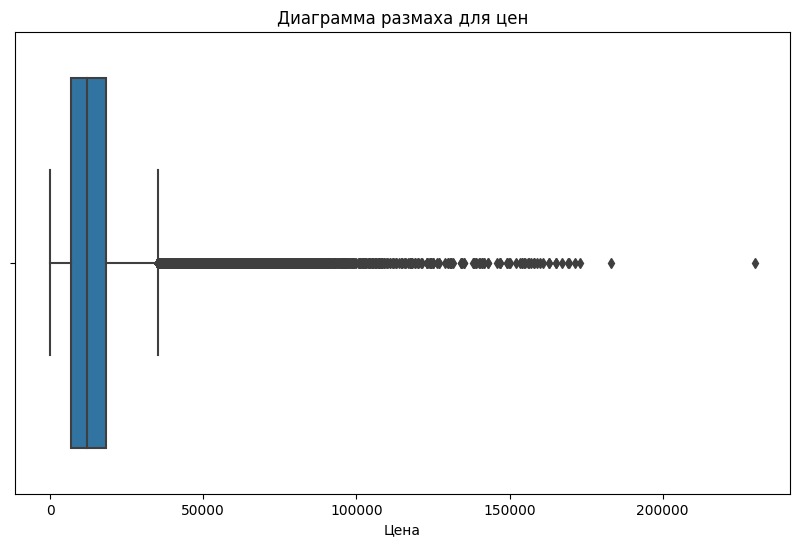

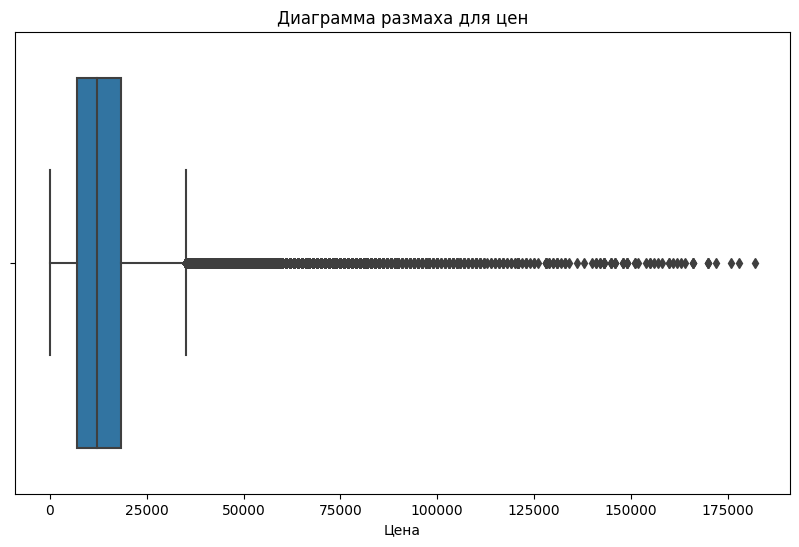

In [23]:
features = ['sellingprice', 'mmr']
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[feature])
    plt.title('Диаграмма размаха для цен')
    plt.xlabel('Цена')
    plt.show()

In [24]:
df = df[df['sellingprice'] <= 175000]

In [25]:
df=df.drop('vin', axis=1)

In [27]:
X = df.drop('sellingprice', axis=1)
y = df['sellingprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
cat_features=['make', 'model', 'trim', 'body', 'state', 'color', 'interior', 'seller', 'saledate', 'country', 'type']
params = {
    'iterations': 1000,
    'learning_rate': 0.01,
    'depth': 8,
    'random_state': 42,
    'eval_metric': 'RMSE',
    'l2_leaf_reg': 3,
    'loss_function': 'RMSE'
}

train_data = Pool(data=X_train, label=y_train, cat_features=cat_features)

model = CatBoostRegressor(**params )
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test))

y_pred = model.predict(X_test)
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['price'], 
    mode='regression' 
)

i = 0  
exp = explainer.explain_instance(
    data_row=X_test.iloc[i],
    predict_fn=model.predict
)

exp.show_in_notebook(show_table=True, show_all=False)

0:	learn: 9645.6702116	test: 9661.0889834	best: 9661.0889834 (0)	total: 683ms	remaining: 11m 21s
1:	learn: 9557.1664063	test: 9572.5379757	best: 9572.5379757 (1)	total: 1.15s	remaining: 9m 34s
2:	learn: 9469.1374844	test: 9484.4014349	best: 9484.4014349 (2)	total: 1.69s	remaining: 9m 22s
3:	learn: 9382.3883150	test: 9397.6340954	best: 9397.6340954 (3)	total: 2.22s	remaining: 9m 12s
4:	learn: 9296.2402230	test: 9311.4332780	best: 9311.4332780 (4)	total: 2.73s	remaining: 9m 4s
5:	learn: 9211.7970475	test: 9226.7243752	best: 9226.7243752 (5)	total: 3.4s	remaining: 9m 22s
6:	learn: 9126.8217681	test: 9141.6765935	best: 9141.6765935 (6)	total: 3.93s	remaining: 9m 17s
7:	learn: 9043.0166161	test: 9057.8565428	best: 9057.8565428 (7)	total: 4.45s	remaining: 9m 11s
8:	learn: 8960.0475137	test: 8974.7247597	best: 8974.7247597 (8)	total: 4.96s	remaining: 9m 6s
9:	learn: 8878.1910075	test: 8892.8065594	best: 8892.8065594 (9)	total: 5.47s	remaining: 9m 1s
10:	learn: 8797.2430770	test: 8811.8641632	

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def plot_predictions(y_test, y_pred):
    """
    Функция строит графики реальных и предсказанных значений, график остатков и выводит значения метрик.

    Параметры:
    y_test (array-like): 
        Реальные значения.
    y_pred (array-like):
        Предсказанные значения.
    """
    fig, axs = plt.subplots(4, 1, figsize=(10, 20))
    line = np.linspace(min(y_test), max(y_test), 1000)

    axs[0].scatter(y_test, y_test, color='blue')
    axs[0].plot(line, line, color='green', alpha=0.1)
    axs[0].set_title('Реальные значения')
    axs[0].set_xlabel('Реальные значения')
    axs[0].set_ylabel('Реальные значения')

    axs[1].scatter(y_test, y_pred, color='red')
    axs[1].plot(line, line, color='green', alpha=0.1)
    axs[1].set_title('Предсказанные значения')
    axs[1].set_xlabel('Реальные значения')
    axs[1].set_ylabel('Предсказанные значения')

    axs[2].scatter(y_test, y_test, color='blue', alpha=0.6, label='Реальные значения')
    axs[2].scatter(y_test, y_pred, color='red', alpha=0.6, label='Предсказанные значения')
    axs[2].plot(line, line, color='green', alpha=0.1)
    axs[2].set_title('Предсказанные значения наложенные на реальные значения')
    axs[2].set_xlabel('Реальные значения')
    axs[2].set_ylabel('Предсказанные значения')
    axs[2].legend()

    residuals = y_test - y_pred
    axs[3].scatter(y_test, residuals, color='purple')
    axs[3].axhline(y=0, color='green', alpha=0.1)
    axs[3].set_title('График остатков')
    axs[3].set_xlabel('Реальные значения')
    axs[3].set_ylabel('Остатки')

    plt.tight_layout()
    plt.show()

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Средняя абсолютная ошибка (MAE): {mae:.4f}")
    print(f"Среднеквадратичная ошибка (MSE): {mse:.4f}")
    print(f"Коэффициент детерминации (R^2): {r2:.4f}")
    print(f"\nКорень из среднеквадратичной ошибки (RMSE): {rmse:.4f}")

In [ ]:
plot_predictions(y_test, y_pred)